In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pandas import Timestamp
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import  GradientBoostingClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

In [2]:
pd.set_option('display.max_columns', None)

Загружаем данные

In [3]:
data_row = pd.read_csv('train.csv', engine='python')
test_row = pd.read_csv('test.csv', engine='python')

Создаём функции для подготовки данных

In [4]:
def prepare_train(dataset):
#     Удалёние незначимых столбцов
    dataset = dataset.drop(columns=['agency_name', 'inspector_name', 'violation_street_name', 'violation_zip_code',
                'mailing_address_str_number', 'mailing_address_str_name', 'zip_code',
                'non_us_str_code', 'country', 'violation_description', 'disposition',
                'collection_status', 'grafitti_status', 'payment_date', 'balance_due',
                'clean_up_cost', 'violator_name', 'ticket_id', 'violation_street_number',
                'admin_fee', 'state_fee', 'payment_amount', 'payment_status', 'compliance_detail',
                'city', 'state', 'violation_code'])
#     Отчистка пропусков
    dataset = dataset.dropna()
    dataset = dataset.reset_index(drop=True)
#     Получение значения интевала в днях с момента выявления нарушения и до даты слушаний
    dataset.ticket_issued_date = dataset.ticket_issued_date.astype('datetime64')
    dataset.hearing_date = dataset.hearing_date.astype('datetime64')
    dataset.insert(0,'date', dataset.hearing_date - dataset.ticket_issued_date)
    dataset = dataset.drop(columns=['ticket_issued_date', 'hearing_date'])
    dataset.date[dataset.date<pd.to_timedelta(0)]=pd.to_timedelta(0)
    a = list(dataset.date)
    b = [i.days for i in a]
    dataset.date = b
    del a, b
    target = dataset.compliance
    dataset.drop(columns=['compliance'], inplace=True)
#      Возвращаем обработанные данные, массив ответов
    return dataset, target

In [5]:
# Аналогичная функция для подготовки тестовых данных
def prepare_test(dataset):
    dataset = dataset.drop(columns=['agency_name', 'inspector_name', 'violation_street_name', 'violation_zip_code',
                'mailing_address_str_number', 'mailing_address_str_name', 'zip_code',
                'non_us_str_code', 'country', 'violation_description', 'disposition',
                'grafitti_status', 
                'clean_up_cost', 'violator_name', 'violation_street_number',
                'admin_fee', 'state_fee', 'city', 'state', 'violation_code'])
    dataset.ticket_issued_date = dataset.ticket_issued_date.astype('datetime64')
    dataset.hearing_date = dataset.hearing_date.astype('datetime64')
    dataset.insert(0,'date', dataset.hearing_date - dataset.ticket_issued_date)
    dataset = dataset.drop(columns=['ticket_issued_date', 'hearing_date'])
#     Заполняем пропущенные значения
    dataset.date.fillna(dataset.date.mean(), inplace=True)
    dataset.date[dataset.date<pd.to_timedelta(0)]=dataset.date.mean()
    a = list(dataset.date)
    b = [i.days for i in a]
    dataset.date = b
    del a, b
    ticket = dataset.ticket_id
    dataset.drop(columns=['ticket_id'], inplace=True)
    return dataset, ticket

In [6]:
# Готовим обучающие данные
data, target = prepare_train(data_row)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=6)

In [8]:
# Создаём и обучаем классификатор с подобранными параметрами
modelgb = GradientBoostingClassifier(max_features = 'sqrt', max_depth = 5, n_estimators = 40)
modelgb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=40,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

accuracy 0.9358192750960415
auc 0.7693491375900839


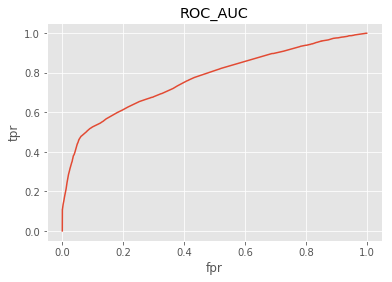

In [9]:
# Получаем оценку и строим roc кривую
gb_predict_p = modelgb.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, gb_predict_p[:,1])
plt.plot(fpr,tpr)
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.title('ROC_AUC')
print('accuracy', modelgb.score(X_test, y_test))
print('auc', roc_auc_score(y_test, gb_predict_p[:,1]))

In [10]:
modelgb = GradientBoostingClassifier(max_features = 'sqrt', max_depth = 5, n_estimators = 40)
modelgb.fit(data, target)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=40,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [11]:
# Готовим тестовые данные
test, ticket = prepare_test(test_row)
# Предсказываем вероятности
predicted = modelgb.predict_proba(test)[:,1]

In [12]:
# Сохраняем результат в требуемом формате
result = pd.concat([ticket, pd.Series(predicted, name='probability')], axis=1)
result.to_csv('result.csv')